# Regresja liniowa za pomocą TensorFlow

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Przygotowanie danych

Ponownie wykorzystamy problem przewidywania cen domów w Bostonie. Poniższy kod wczytuje dane i dzieli na trzy podzbiory: uczący, walidujący i testowy w proporcji 70%/10%/20%. Dane reprezentowane są jako obiekty typu `torch.Tensor`, tj. tensory (uogólnienie macierzy na więcej wymiarów) charakterystyczne dla biblioteki PyTorch. Parametr `dtype` wymusza konwersję na typ `float`

In [25]:
from sklearn.datasets import load_boston
boston = load_boston()
X = torch.tensor(boston['data'], dtype=torch.float)
y = torch.tensor(boston['target'], dtype=torch.float)

In [26]:
n, p = X.shape
n_train = int(.7*n)
n_validation = int(.1*n)
indices = np.random.permutation(n)
X = X[indices]
y = y[indices]
X_train = X[:n_train, :]
y_train = y[:n_train]
X_validation = X[n_train:n_train+n_validation, :]
y_validation = y[n_train:n_train+n_validation]
X_test = X[n_train+n_validation:, :]
y_test = y[n_train+n_validation:]

## Konstrukcja prostego regresora

PyTorch opiera się na modułach (obiektach klasy `torch.nn.Module`), które są komponowane w graf obliczeń. Każdy z modułów może wykorzystywać parametry (obiekty klasy `torch.nn.Parameter`), dla których mogą być automatycznie liczone gradienty i które (potencjalnie) podlegają optymalizacji.

Rozpoczynamy od skonstruowania pojedynczej warstwy liniowej - tj. warstwy implementującej operację $\hat{y} = Xw + b$

In [56]:
regressor = nn.Linear(p, 1) # p cech na wejściu, jedna cecha na wyjściu

Do obliczania wartości błędu wykorzystamy błąd średniokwadratowy. PyTorch dostarcza gotowej implementacji w postaci klasy `torch.nn.MSELoss()`, natomiast ze względów dydaktycznych zaimplementujemy to samodzielnie. Kluczowe jest odziedziczenie po klasie `torch.nn.Module`, a następnie przeciążenie metody `forward`, która jest odpowiedzialna za wykonywanie obliczeń "w przód". Obliczenia w tył (tj. przepływ gradientów) jest realizowany automatycznie.

In [57]:
class MSE(nn.Module):
    def __init__(self):
        super(MSE, self).__init__()
        
    def forward(self, prediction, target):
        return ((prediction-target)**2).mean()

mse = MSE()

Chcemy, żeby zmienne `W` oraz `b` automatycznie się zoptyamlizowały w procesie uczenia. Wykorzystamy w tym celu klasę `torch.optim.Adam`, która implementuje pewne ulepszenie algorytmu Gradient Descent. Tworzymy obiekt `opt`, który będzie odpowiedzialny za optymalizację parametrów regresora, uzyskanych przez wywołanie `regressor.parameters()`

In [60]:
opt = optim.Adam(regressor.parameters())

## Uruchomienie obliczeń


Zaimplementujemy uczenie mini-batch przez `n_epoch` epok. W ramach każdej z epok:
1. Wymieszamy indeksy zbioru treningowego
2. Będziemy iterowali po tych indeksach, biorąc za każdym razem `batch_size` z nich. Za pomocą tych indeksów wybierzemy obiekty wykorzysytwane w danym kroku do uczenia.
3. Zerujemy gradienty zapamiętane przez optymalizator (`opt.zero_grad()`)
4. Uruchamiamy regresor, obliczamy błąd średniokwadratowy
5. Obliczamy gradienty (`mse_value.backward()`)
6. Aplikujemy gradienty (`opt.step()`)
7. Zapamiętujemy wartość MSE. Wywołujemy metodę `detach()`, żeby zapamiętane MSE nie było powiązane ze swoimi gradientami.

Po wykonaniu epoki uśredniamy zebrane MSE i zapmiętujęmy tę wartość

In [61]:
mse_values = []
batch_size = 100
n_epoch = 1000
for epoch in range(n_epoch):
    indices = np.random.permutation(n_train)
    mse_epoch = []
    for start in range(0, len(indices), batch_size):
        end = min(start + batch_size, len(indices))
        indices_batch = indices[start:end]
        X_batch = X_train[indices_batch, :]
        y_batch = y_train[indices_batch]
        opt.zero_grad()
        y_pred = regressor(X_batch).reshape((-1,))
        mse_value = mse(y_pred, y_batch)
        mse_value.backward()
        opt.step()
        mse_epoch.append(mse_value.detach())
    mse_values.append(np.mean(mse_epoch))    

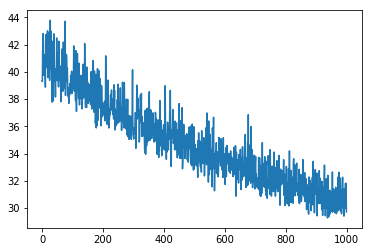

In [62]:
plt.plot(mse_values)
plt.show()

Uruchom ponownie powyższe dwie komórki z kodem. Ponieważ regresor i optymalizator ciągle reprezentują te same obiekty, więc już nauczone wartości parametrów są pamiętane i wykres wygląda zupełnie inaczej. Żeby powrócić do stanu początkowego trzeba stworzyć na nowo obiekty `regressor` i `opt`.

## Early stopping

Zaimplementuj early stopping: Po każdej epoce uczenia oblicz wartość MSE za pomocą zbiorów `X_validation` i `y_validation`. Zwróć uwagę na wywołanie metod `regressor.train()` i `regressor.eval()`, które przełączają moduł między trybem uczenia, a trybem wykonywania faktycznych obliczeń. Pamiętaj, żeby nie wywoływać metody `opt.step()` po wykonaniu obliczeń na zbiorze walidującym. Przerwij uczenie jeżeli przez ostatnie 100 epok nie udało się znaleźć lepszej wartości `mse`. Zapamiętuj warotści `mse` uzyskane podczas uczenia i podczas walidacji (odpowiednio w `train_mses` i `validation_mses`), a następnie narysuj je na wykresie. Wypisz, w którym kroku zostało przerwane uczenie.

In [71]:
regressor = nn.Linear(p, 1) # p cech na wejściu, jedna cecha na wyjściu
opt = optim.Adam(regressor.parameters())

train_mses = []
validation_mses = []
batch_size = 100
n_epoch = 10000
for epoch in range(n_epoch):
    regressor.train()
    for start in range(0, len(indices), batch_size):
        ...
    regressor.eval()
    ...

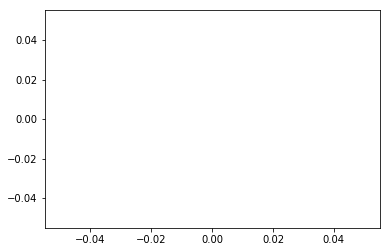

In [66]:
plt.plot(train_mses, 'b') #błąd uczenia na niebiesko
plt.plot(validation_mses, 'r') # błąd walidacji na czerwono
plt.show()

## Regularyzacja L1

Zaimplementuj regularyzację L1 zgodnie z poniższym wzorem, implementując metodę `forward` w klasie `MSEWithL1`

$$ cost = MSE + \alpha \sum_{i=1}^n \left|w_i\right| $$

Wykorzystaj metody `abs()` i `sum()` obiektów klasy `torch.Tensor`

In [73]:
class MSEWithL1(nn.Module):
    
    def __init__(self, alpha, weight):
        super(MSEWithL1, self).__init__()
        self._weight = weight
        self._alpha = alpha
        
    def forward(self, pred, target):
        return ((pred-target)**2).mean() + self._alpha * self._weight.abs().sum()

Przetestuj uzyskane rozwiązanie: ucz przez 5000 epok dla wartości każdej z następujacych wartości $\alpha$: 0.01, 0.1, 1, 10, 100. Za każdym razem twórz na nowo regresor i optymalizator. Zbieraj co epokę MSE (nie całkowity koszt z klasy `MSEWithL1`) na zbiorze walidującym i narysuj je na wspólnym wykresie dla wszystkich 5 wartości hiperparametru $\alpha$. Która z wartości $\alpha$ jest najlepsza?

In [80]:
mse = MSE()

mses = {}
for alpha in [0.01, 0.1, 1, 10, 100]:    
    regressor = nn.Linear(p, 1) # p cech na wejściu, jedna cecha na wyjściu
    opt = optim.Adam(regressor.parameters())
    cost = MSEWithL1(alpha, regressor.weight)
    mses[alpha] = [] # tu zachowuj wartości błędu na zbiorze walidującym    
    for epoch in range(5000):
        regressor.train()
        indices = np.random.permutation(n_train)
        for start in range(0, len(indices), batch_size):
            end = min(start + batch_size, len(indices))
            indices_batch = indices[start:end]
            X_batch = X_train[indices_batch, :]
            y_batch = y_train[indices_batch]
            opt.zero_grad()
            y_pred = regressor(X_batch).reshape((-1,))
            cost(y_pred, y_batch).backward()            
            opt.step()        
        regressor.eval()
        y_pred = regressor(X_validation).reshape((-1,))
        mses[alpha].append(mse(y_pred, y_validation))

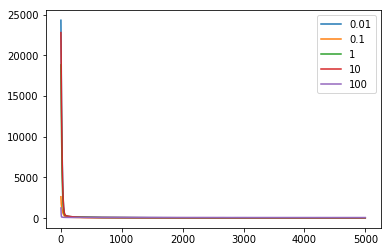

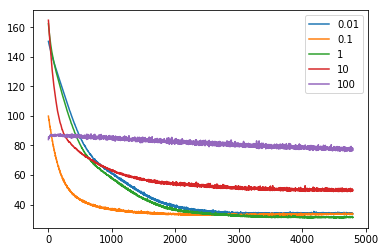

In [82]:
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()
for alpha in sorted(mses.keys()):
    plt.plot(mses[alpha][200:])
plt.legend([str(alpha) for alpha in sorted(mses.keys())])
plt.show()

Która z wartości $\alpha$ jest najlepsza? ...